<a href="https://colab.research.google.com/github/ggruszczynski/gpu_colab/blob/main/90_taichi_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install taichi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00


# Wave equation

In this tutorial we will solve the wave equation on GPU using taichi framework.

## Finite difference wave equation

Introduction adopted from [here](https://docs.tclb.io/tutorials/model-development/1.-finite-difference-wave-equation).

---

We want to discretize the [Wave Equation](https://en.wikipedia.org/wiki/Wave_equation):

$$ \ddot{h} = c^2\Delta h $$

For this purpose we will use Finite Difference method. First we change the equation into two first order (in time) equations:

$$ \begin{eqnarray}
\dot{v} &=& c^2\Delta h \\
\dot{h} &=& v
\end{eqnarray} $$

Now let us discretise the [Laplace operator](https://en.wikipedia.org/wiki/Laplace_operator) with simple finite difference (in 2D):

$$
\Delta h \approx \frac{(h_{i-1,j}+h_{i+1,j}+u_{i,j-1}+h_{i,j+1}-4h_{i,j})}{(dx^2)}
$$

Finnaly we will use, what is called [Semi-implicit Euler rule](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method) to integrate this equation in time. This will give us a following system:

$$ \begin{eqnarray}
v^{n+1}_{i,j} &=& v^n_{i,j} +  c^2\Delta h^n \; \delta t \\
h^{n+1}_{i,j} &=& h^n_{i,j} +  v^{n+1}_{i,j} \; \delta t
\end{eqnarray} $$

The semi-implicit-ness can be seen in the index of `v` in the second line.

Finally, we can add a (linearized) damping effect:

$$ \begin{eqnarray}
v^{n+1}_{i,j} &=& v^n_{i,j} +  (c^2\Delta h^n - \zeta v^n_{i,j}) \; \delta t \\
h^{n+1}_{i,j} &=& h^n_{i,j} +  v^{n+1}_{i,j} \; \delta t
\end{eqnarray} $$

In [15]:
import matplotlib.pyplot as plt
import taichi as ti

[Taichi] Starting on arch=cuda
waves


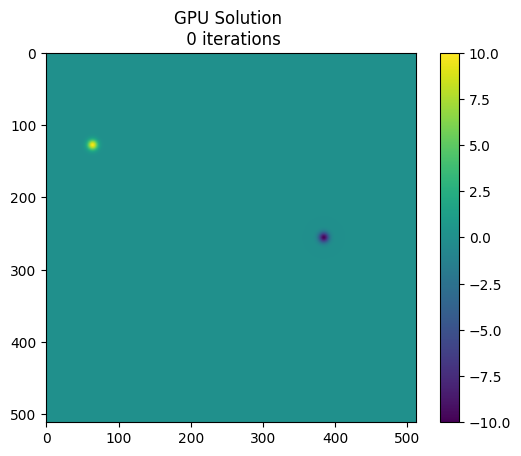

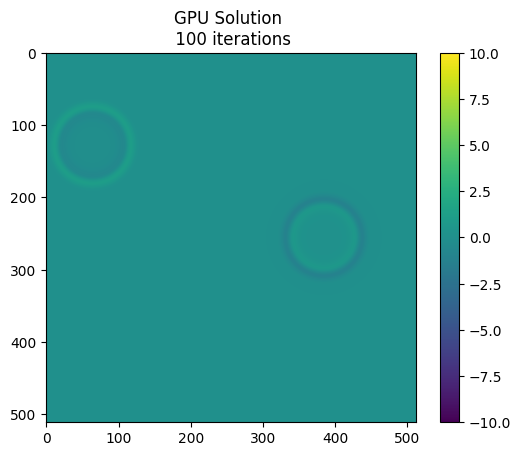

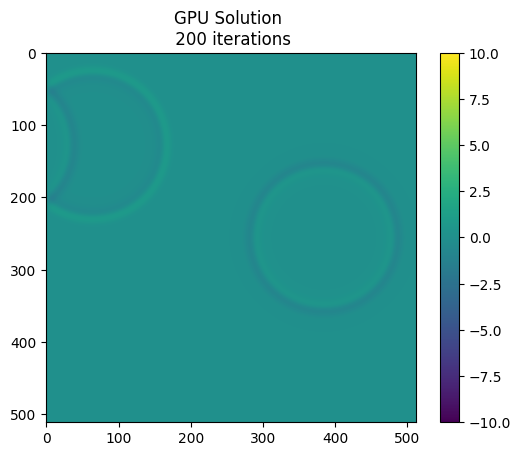

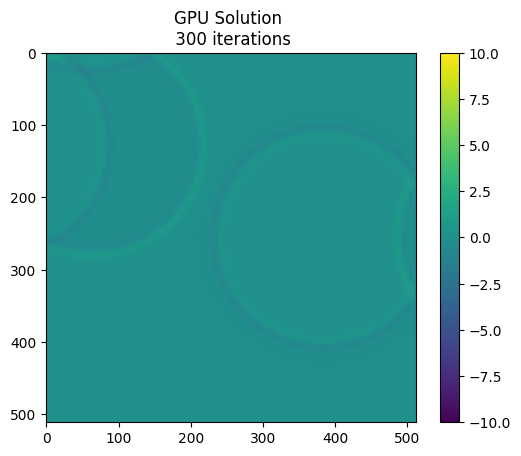

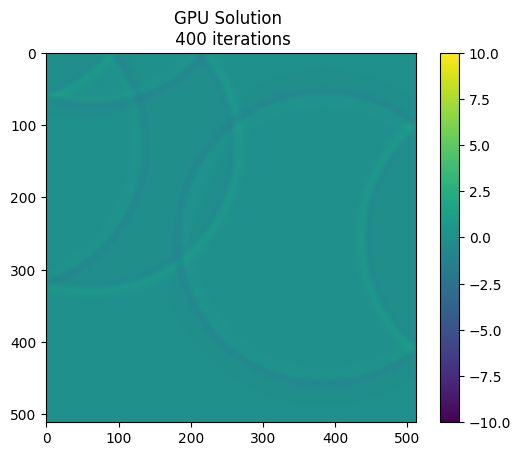

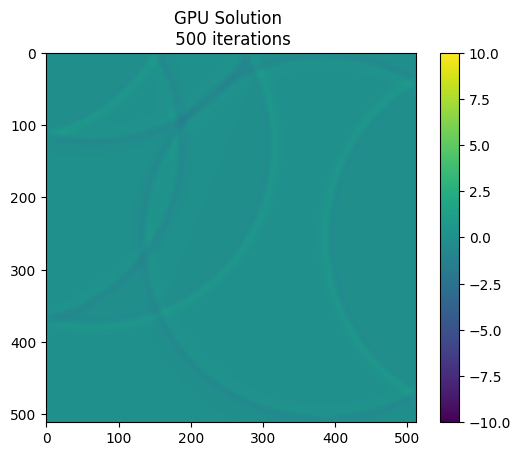

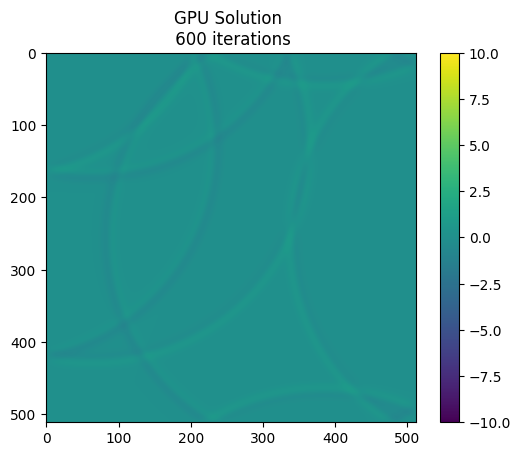

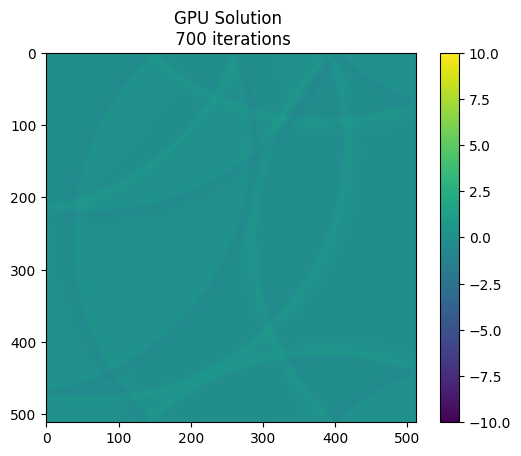

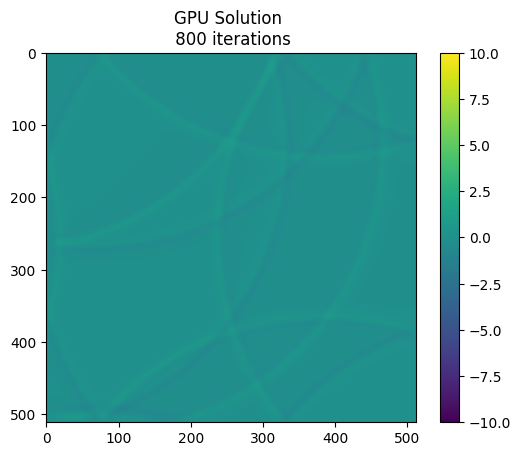

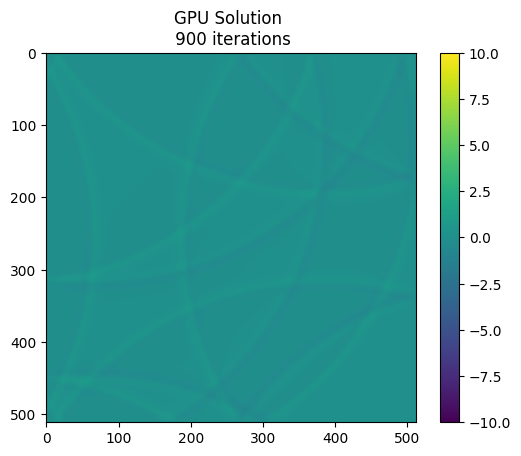

In [16]:
# Insipiration
# https://github.com/taichi-dev/taichi/blob/master/python/taichi/examples/simulation/waterwave.py
# https://docs.tclb.io/tutorials/model-development/1.-finite-difference-wave-equation/


ti.init(arch=ti.gpu)

c2 = 1.0        # wave propagation speed
damping = 0.01  # larger damping makes wave vanishes faster when propagating
dx = 0.02
dt = 0.01
shape = 512, 512

h = ti.field(dtype=float, shape=shape) # like height
v = ti.field(dtype=float, shape=shape)
h.fill(0)
v.fill(0)

@ti.kernel
def create_wave(amplitude: ti.f32, x: ti.f32, y: ti.f32):
    for i, j in ti.ndrange((1, shape[0] - 1), (1, shape[1] - 1)):
        r2 = (i - x) ** 2 + (j - y) ** 2
        h[i, j] = h[i, j] + amplitude * ti.exp(-0.02 * r2)


@ti.func
def laplacian_h(i, j):
    return (-4 * h[i, j] + h[i, j - 1] + h[i, j + 1] + h[i + 1, j] + h[i - 1, j]) / (dx**2)


@ti.kernel
def update():
    for i, j in ti.ndrange((1, shape[0] - 1), (1, shape[1] - 1)):
        v[i, j] = v[i, j] + (c2 * laplacian_h(i, j) - damping * v[i, j]) * dt

    for i, j in ti.ndrange((1, shape[0] - 1), (1, shape[1] - 1)):
        h[i, j] = h[i, j] + v[i, j] * dt




def main():
    print("waves")

    create_wave( 10, int(0.25*shape[0]), int(0.125*shape[0]) )
    create_wave(-10, int(0.5*shape[0]),  int(0.75*shape[0])  )

    for i in range(1000):
      update()
      if i % 100 == 0:
        plt.imshow(h.to_numpy(), vmin = -10, vmax =10, cmap='viridis')
        plt.colorbar()
        plt.title(f'GPU Solution \n {i} iterations')
        plt.show()

if __name__ == "__main__":
    main()